# Importing the required libraries 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


# Setting the visualization parameters and labels

In [4]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the Data

In [6]:
df = pd.read_csv("D:/creditcard.csv")

# Exploration

In [8]:
df.shape #No of rows and columns

(284807, 31)

In [10]:
df.isnull().values.any() #Checking if we have any null values

False

## Checking the class distribution

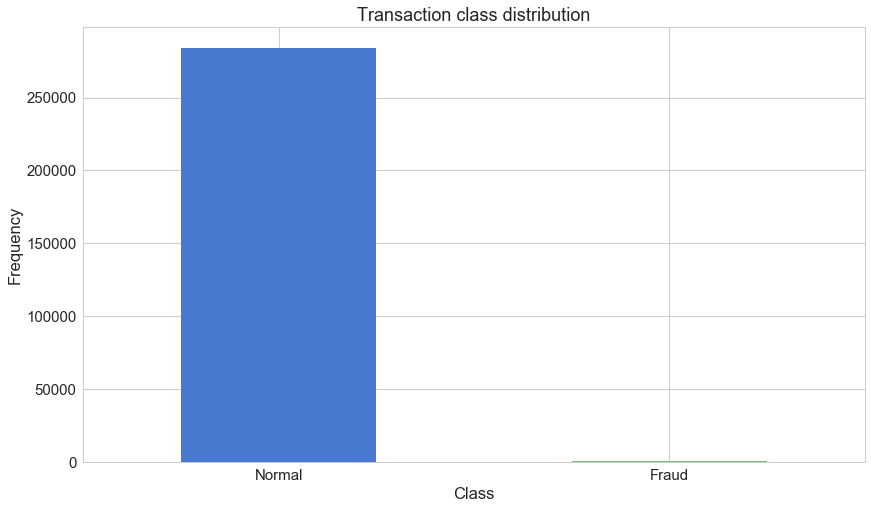

In [11]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [13]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape #There are just 492 Frauds, High Imbalance.

(492, 31)

In [14]:
normal.shape 

(284315, 31)

## How different are the amount of money used in different transaction classes?

In [15]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [16]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Insights of class with more graphical representation

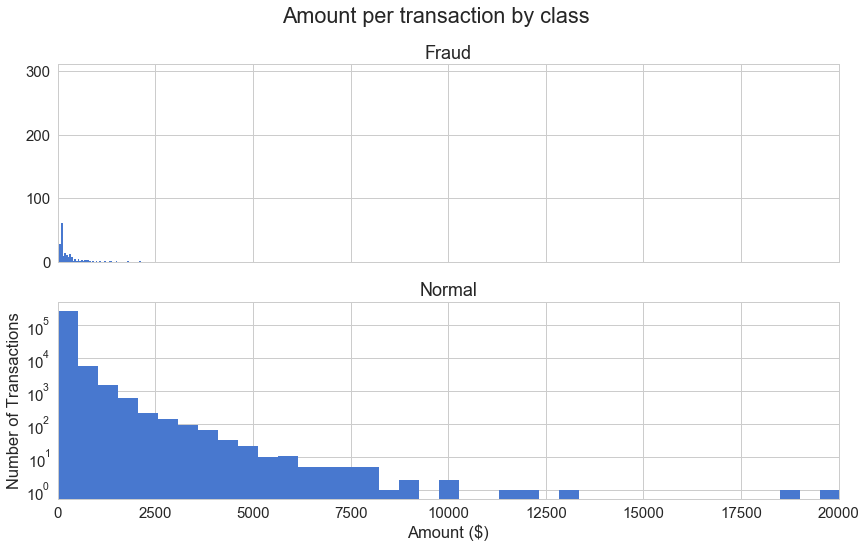

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


## Does time factor has more impact on Fraud transactions?

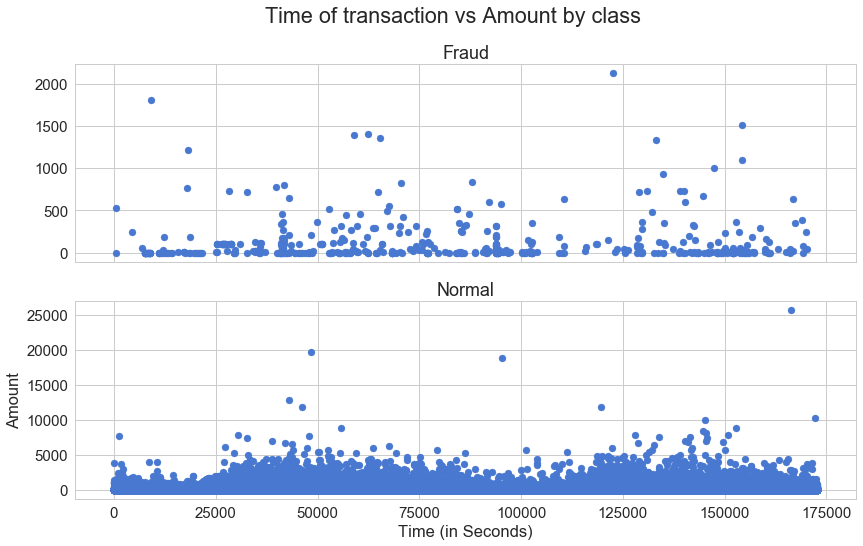

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### It seems like time of the transcation does n't really matters

## Model Construction

### Preparing the data

In [20]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1) #Dropping the time of transaction as it does n't have any impact on the Fraud data
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) # Scaling the Amount variable

In [21]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [22]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.8414 - acc: 0.5723 - val_loss: 0.8269 - val_acc: 0.6217
Epoch 2/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7836 - acc: 0.6377 - val_loss: 0.8028 - val_acc: 0.6522
Epoch 3/100
227451/227451 [==============================] - 7s 32us/step - loss: 0.7678 - acc: 0.6454 - val_loss: 0.7977 - val_acc: 0.6460
Epoch 4/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7600 - acc: 0.6478 - val_loss: 0.7878 - val_acc: 0.6509
Epoch 5/100
227451/227451 [==============================] - 7s 32us/step - loss: 0.7566 - acc: 0.6508 - val_loss: 0.7867 - val_acc: 0.6486
Epoch 6/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7555 - acc: 0.6526 - val_loss: 0.7850 - val_acc: 0.6518
Epoch 7/100
227451/227451 [==============================] - 8s 33us/step - loss: 0.7539 - acc: 0.6537 - val_

Epoch 59/100
227451/227451 [==============================] - 7s 32us/step - loss: 0.7450 - acc: 0.6685 - val_loss: 0.7733 - val_acc: 0.6738
Epoch 60/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7450 - acc: 0.6685 - val_loss: 0.7783 - val_acc: 0.6715
Epoch 61/100
227451/227451 [==============================] - 7s 33us/step - loss: 0.7446 - acc: 0.6695 - val_loss: 0.7758 - val_acc: 0.6685
Epoch 62/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7445 - acc: 0.6699 - val_loss: 0.7738 - val_acc: 0.6655
Epoch 63/100
227451/227451 [==============================] - 7s 32us/step - loss: 0.7446 - acc: 0.6703 - val_loss: 0.7734 - val_acc: 0.6708
Epoch 64/100
227451/227451 [==============================] - 8s 35us/step - loss: 0.7446 - acc: 0.6708 - val_loss: 0.7734 - val_acc: 0.6656
Epoch 65/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7443 - acc: 0.6715 - val_loss: 0.7745 - val_acc: 0.6704
Epoch 66/100


In [24]:
autoencoder = load_model('model.h5') #Saving the model

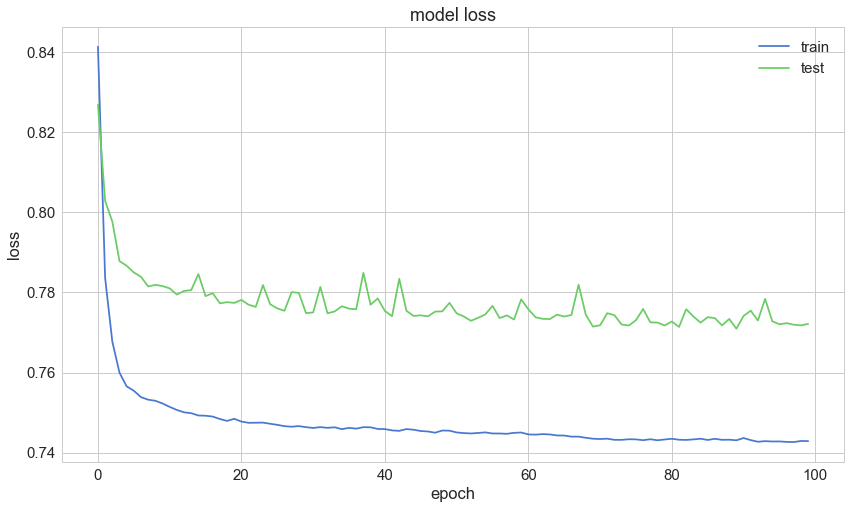

In [25]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [26]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.764087,0.001720
std,3.446044,0.041443
min,0.031660,0.000000
25%,0.255387,0.000000
50%,0.399419,0.000000
75%,0.630631,0.000000
max,258.919675,1.000000


## Reconstruction error without fraud

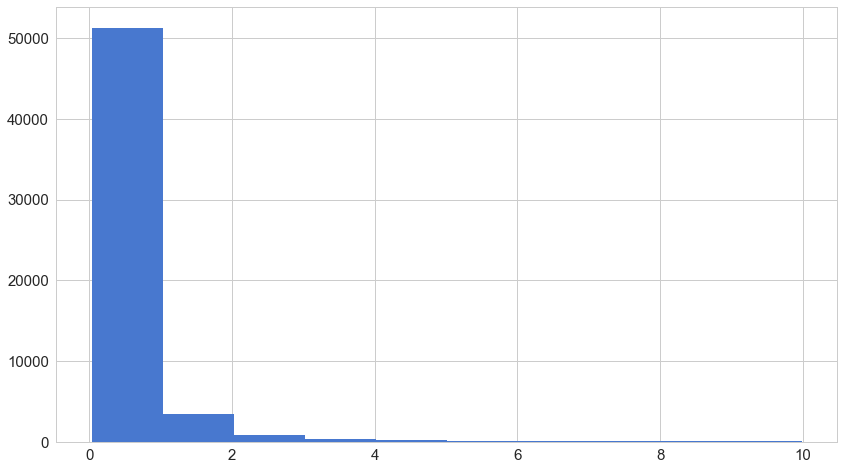

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


## Reconstruction error with fraud

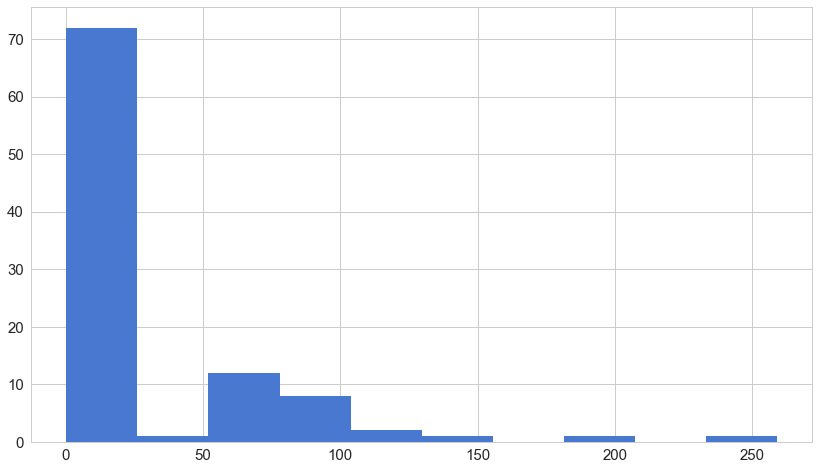

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)


# Confusion Matrix and Metrics Evaluation



In [30]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

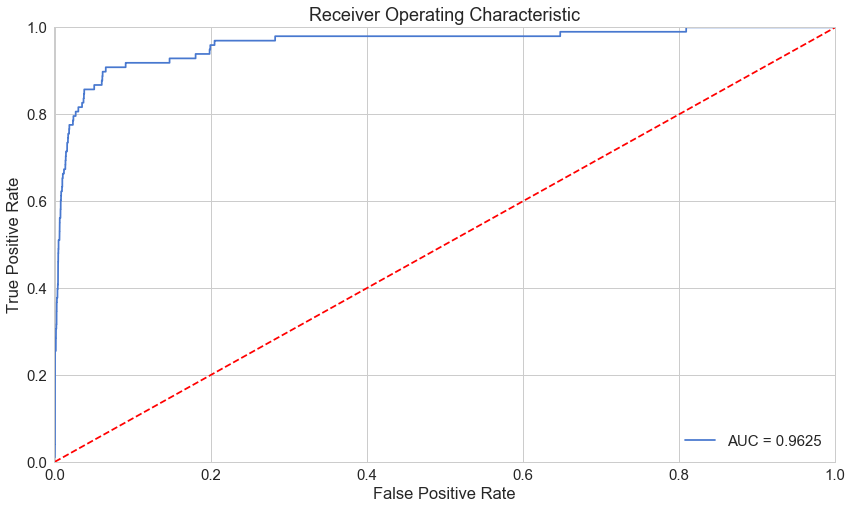

In [31]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

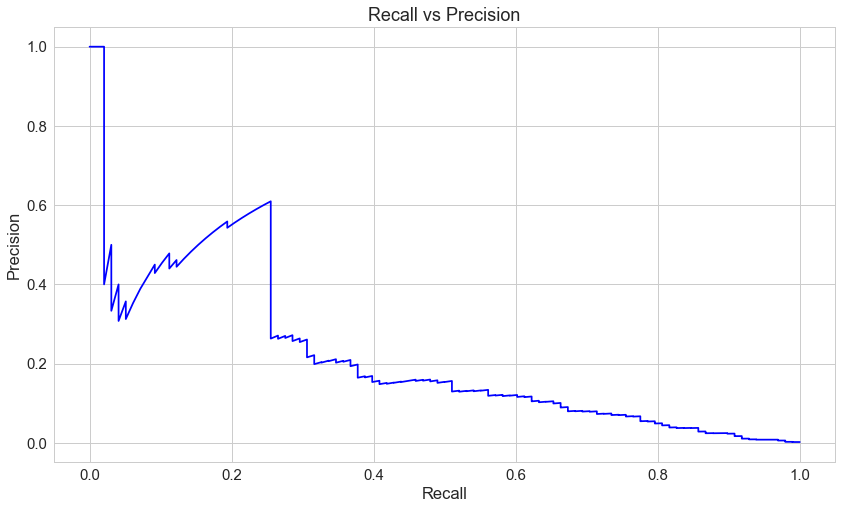

In [32]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

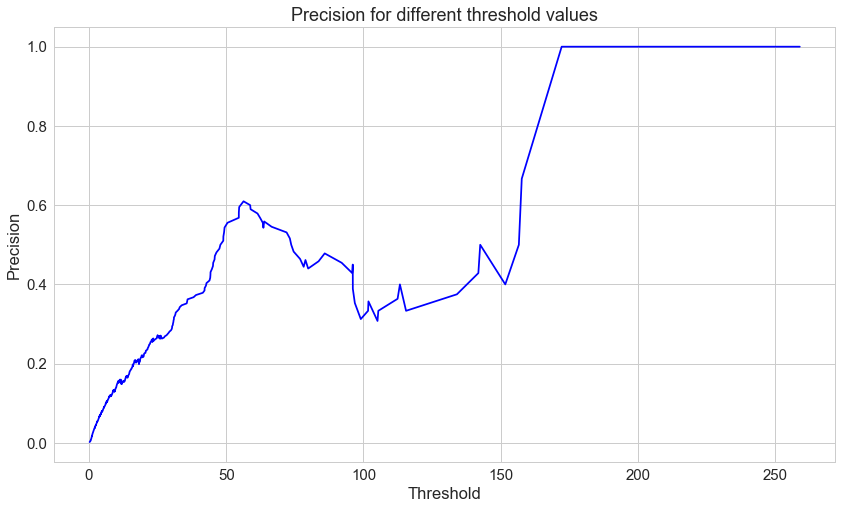

In [33]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


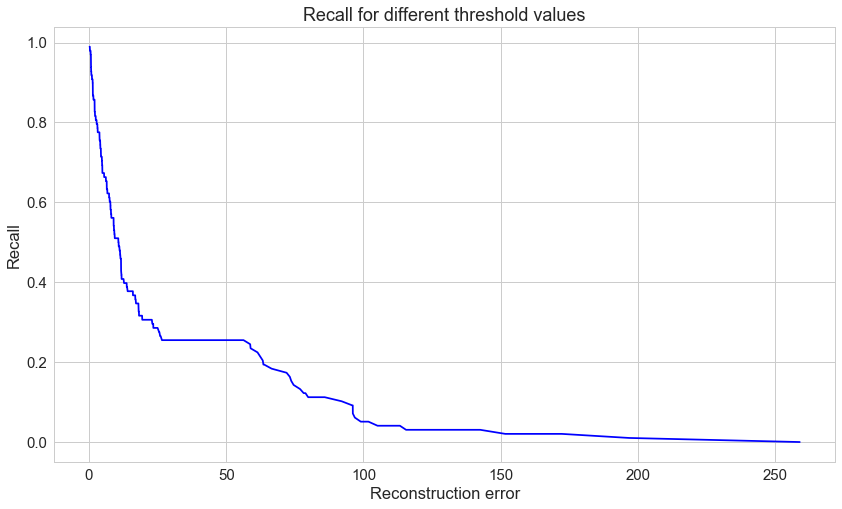

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [36]:
threshold = 2.9

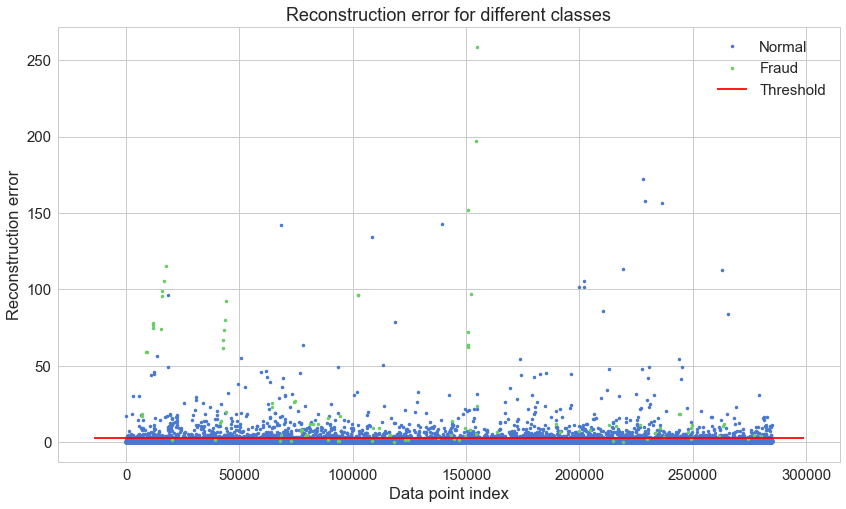

In [37]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

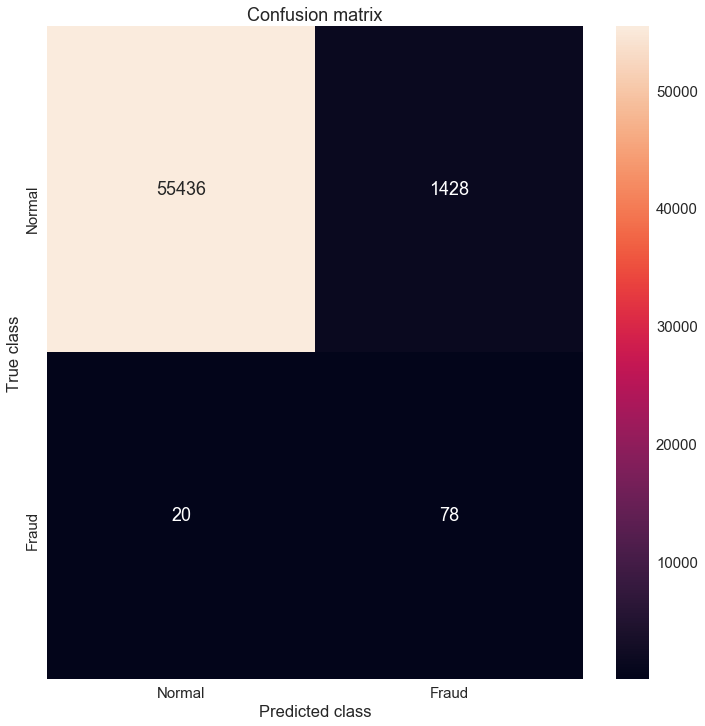

In [38]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()